In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
torch.__version__

'2.1.0'

In [3]:
mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5], std=[0.5]),
                                      transforms.Lambda(lambda x: x.view(-1, 784)),
                                      transforms.Lambda(lambda x: torch.squeeze(x))
                                      ])
# mnist_transforms = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Lambda(lambda x: x.view(-1, 784)),
#                                       transforms.Lambda(lambda x: torch.squeeze(x))
#                                       ])


data = datasets.MNIST(root='.', download=True, transform=mnist_transforms)

mnist_dataloader = DataLoader(data, batch_size=128, shuffle=True, num_workers=2) 

In [4]:
class Generator(nn.Module):
  '''
  Generator class. Random input of size 100 and a label (from 0 to 9) and 
outputs a flattened image 28x28=784. The objective is to output (conditional) images that are indistinguishable 
  from the real MNIST digits.
  '''

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_features=100, out_features=256),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=256, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=1024),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=1024, out_features=28*28),
                                nn.Tanh())

  def forward(self, x):
    
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x



In [5]:

class Discriminator(nn.Module):
  '''
  Discriminator class. The input is a flattened image of size 28x28=784 and a label (0 to 9)
  and outputs the probability of the input being real( from the MNIST dataset) or fake (generated by G)
  '''

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(in_features=28*28, out_features=1024),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=1024, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=256),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=256, out_features=1),
                                nn.Sigmoid())
    
  def forward(self, x, y): 
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x


In [6]:
nz=100
device=torch.device("cuda" if(torch.cuda.is_available()) else "cpu")
G=Generator().to(device)
D=Discriminator().to(device)
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(5,100, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(beta1, 0.999))
# optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=0.0002)
optimizerG = optim.Adam(G.parameters(), lr=0.0002)


$$
\min_G\max_D V(D,G)=\mathbb{E}_{x\sim p_{data}}[\log D(x)]+\mathbb{E}_{z\sim p_z}[\log(1-D(G(z)))]

$$

In [7]:
def generate_imgs(z=None):
    nimgs_per_cat=5
    with torch.no_grad():
        if z is None:
            z = torch.randn(nimgs_per_cat, 100, device=device)
        #y = torch.randint(0, 10, size=(10,), device=device)
        y=torch.empty(nimgs_per_cat, dtype=torch.long).fill_(0).to(device)
        g_imgs = G(z, y).view(nimgs_per_cat,1,28,28).detach()
        for i in range(1,10):
            y=torch.empty(5, dtype=torch.long).fill_(i).to(device)
            g_imgs2 = G(z, y).view(nimgs_per_cat,1,28,28).detach()
            g_imgs=torch.vstack((g_imgs,g_imgs2))
    g_imgs=make_grid(g_imgs,nrow=nimgs_per_cat,normalize=True,padding=1).cpu()
    return np.transpose(g_imgs,(1,2,0))

In [8]:
epochs=500
inter_results=[]
for epoch in range(epochs):
    for i, (x, labels) in enumerate(mnist_dataloader):
        # Sample random noise and labels
        z = torch.randn(x.shape[0], 100, device=device)
        y = torch.randint(0, 10, size=(x.shape[0],), device=device)
        x = x.to(device)
        labels=labels.to(device)
        # Generate images
        generated_imgs = G(z, y)
        # Calculate the discriminator output for fake images
        d_out_fake = D(generated_imgs.detach(), y)
        # Calculate the discriminator output for real images
        d_out_real = D(x, labels)

        # discriminator loss  
        d_loss = criterion(d_out_fake, torch.zeros_like(d_out_fake))\
                 +criterion(d_out_real, torch.ones_like(d_out_real)) 
        D.zero_grad()
        d_loss.backward()
        optimizerD.step()
        # loss for the generator
        g_output = torch.squeeze(D(generated_imgs, y))
        g_loss = criterion(g_output, torch.ones_like(g_output))
        G.zero_grad()
        g_loss.backward()
        optimizerG.step()
    if epoch%10==0:
        print(epoch, d_loss.item(), g_loss.item())
        inter_results.append(generate_imgs(fixed_noise))


0 0.00033584568882361054 8.337774276733398
10 0.40385013818740845 5.203915596008301
20 0.16180124878883362 5.2244954109191895
30 0.5345731973648071 4.448631286621094
40 0.6968984603881836 3.0821967124938965
50 0.4720614552497864 2.137213706970215
60 0.8800541162490845 2.2360928058624268
70 0.7645671367645264 1.8560165166854858
80 0.8709642887115479 1.648590087890625
90 0.7037773132324219 1.9258508682250977
100 0.7711907625198364 2.1192996501922607
110 0.7346673011779785 1.9120228290557861
120 0.599938154220581 1.9673798084259033
130 0.8318141102790833 1.7660678625106812
140 0.6782335042953491 2.118292808532715
150 0.6908958554267883 2.2919111251831055
160 0.556023120880127 1.9597508907318115
170 0.7273602485656738 1.8524234294891357
180 0.4756370186805725 2.2542855739593506
190 0.5562402606010437 2.169248580932617
200 0.5366783738136292 2.381309986114502
210 0.4955134689807892 2.4796388149261475
220 0.45339930057525635 2.3403053283691406
230 0.5906828045845032 2.2124478816986084
240 0.

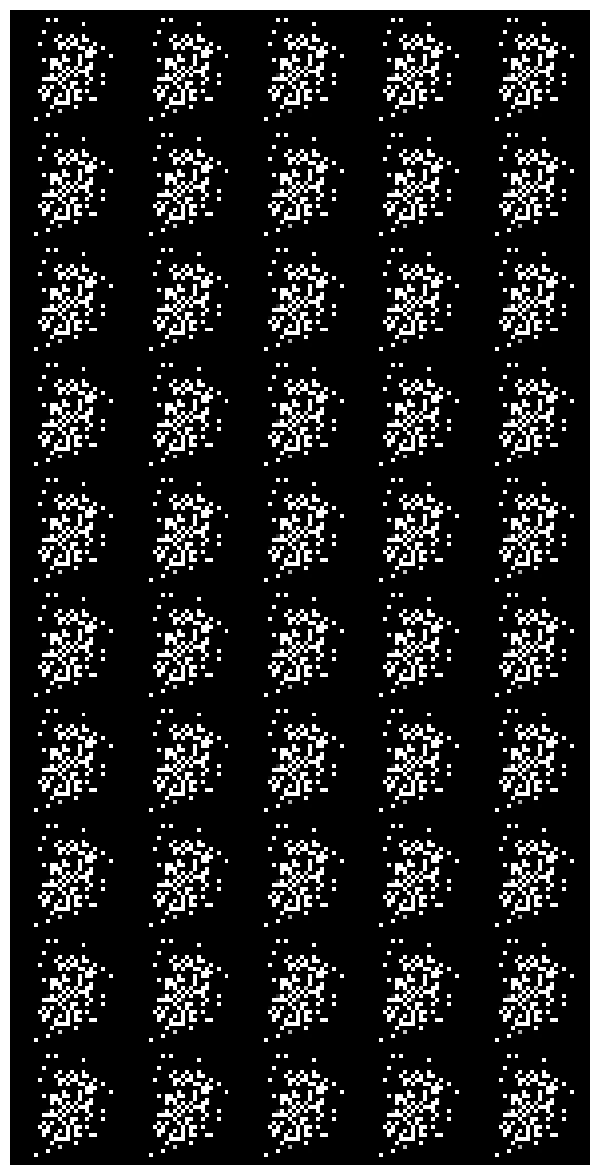

In [9]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(inter_results[0])

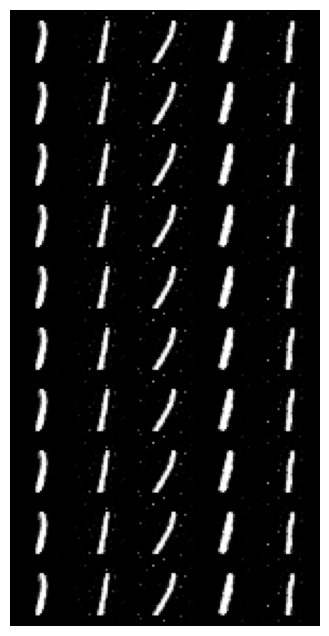

In [10]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in inter_results]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())